<h2>Import libraries</h2>

In [1]:
import os
import time
import numpy as np
import cv2
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import OneHotEncoder
import shutil
import cntk as C

<h2>parameters and constants</h2>

In [2]:
train_set_len = 70000
num_class = 10
g_input_dim_noise = 100
g_hidden_dim = 1024
g_output_dim = 784
d_input_dim = 784
d_hidden_dim = 1024
d_output_dim = 1
max_epoch = 3000
img_h = img_w = 28
gstride = dstride = 2
gkernel = dkernel = 5

<h2>load MNIST data</h2>

In [3]:
mnist = fetch_mldata('MNIST original')
real_img = np.array(mnist.data / 127.5 - 1., dtype=np.float32)
enc = OneHotEncoder(dtype=np.float32)
enc.fit(mnist.target[:, None])
real_code = enc.transform(mnist.target[:, None])

<h2>some helper functions</h2>

In [4]:
def G_sampler(G_model, batch_size, normal=True):
    '''
    get samples from G network
    '''
    digit_code = enc.transform(np.random.randint(0, num_class, batch_size)[:, None])
    if normal:
        mu, sigma = 0, 0.33
        z = np.random.normal(mu, sigma, (batch_size, g_input_dim_noise))
    else:
        z = 2.0 * np.random.random((batch_size, g_input_dim_noise)) - 1.0
    #z[:, :10] = digit_code

    fake_images = G_model.eval({G_model.find_by_name('G_feature_z'): z,
                                G_model.find_by_name('G_feature_code'): digit_code},
                               outputs=G_model.find_by_name('G_out'))

    return z, fake_images, digit_code


def visualize(epoch, batch_size=256, save_model=False):
    '''
    get samples from G network and save it to samples dir
    '''
    global G_net, D_real, G_tensorboard_writer

    # check if folder exist
    p = 'samples/epoch{:05d}'.format(epoch)
    if os.path.isdir(p):
        shutil.rmtree(p)
    os.mkdir(p)
    _, samples, codes = G_sampler(G_net, batch_size)
    for ind, i in enumerate(zip(samples, codes.toarray())):
        code = np.argmax(i[1])
        img = (i[0] + 1) * 127
        img = img.reshape((28, 28))
        cv2.imwrite('samples/epoch{:05d}/epoch{:05d}_ind{:03d}_code{}.jpg'.format(epoch, epoch, ind, code), img)

    if save_model:
        G_net.save(os.path.join(cwd, 'samples', 'epoch{:05d}', 'G_{:05d}.cntk').format(epoch, epoch))
        D_real.save_checkpoint(os.path.join(cwd, 'samples', 'epoch{:05d}', 'D_{:05d}.cntk').format(epoch, epoch))


def create_mb_for_D(mb_size):
    global real_img, real_code

    counter = 0
    while True:
        # create fake batch
        z, fake_img, fake_code = G_sampler(G_net, mb_size)
        #yield fake_img, fake_code

        # create real batch
        if counter + mb_size < train_set_len:
            yield real_img[counter:counter + mb_size].reshape((mb_size, 1, img_h, img_w)), real_code[counter:counter + mb_size], z, fake_code
            counter += mb_size
        else:
            # shuffle
            p = np.random.permutation(real_code.shape[0])
            real_img, real_code = real_img[p], real_code[p]
            counter = 0
            yield real_img[counter:counter + mb_size].reshape((mb_size, 1, img_h, img_w)), real_code[counter:counter + mb_size], z, fake_code


def create_mb_for_G(mb_size):
    while True:
        # create fake samples
        z, _, code = G_sampler(G_net, mb_size)
        yield z, code

<h2>define D and G networks</h2>

In [5]:
def D(x_img, x_code):
    def bn_with_leaky_relu(x, leak=0.2):
        h = C.layers.BatchNormalization(map_rank=1)(x)
        r = C.param_relu(C.constant((np.ones(h.shape) * leak).astype(np.float32)), h)
        return r

    with C.layers.default_options(init=C.normal(scale=0.02)):

        h0 = C.layers.Convolution2D(dkernel, 1, strides=dstride)(x_img)
        h0 = bn_with_leaky_relu(h0, leak=0.2)
        print('h0 shape :', h0.shape)

        h1 = C.layers.Convolution2D(dkernel, 64, strides=dstride)(h0)
        h1 = bn_with_leaky_relu(h1, leak=0.2)
        print('h1 shape :', h1.shape)

        h2 = C.layers.Dense(256, activation=None)(h1)
        h2 = bn_with_leaky_relu(h2, leak=0.2)
        print('h2 shape :', h2.shape)

        h2_aug = C.splice(h2, x_code)

        h3 = C.layers.Dense(256, activation=C.relu)(h2_aug)

        h4 = C.layers.Dense(1, activation=C.sigmoid, name='D_out')(h3)
        print('h3 shape :', h4.shape)

        return h4


def G(z, code):
    def bn_with_relu(x, activation=C.relu, name='BN'):
        h = C.layers.BatchNormalization(map_rank=1, name=name)(x)
        return C.relu(h, name=name + '_relu')

    i = C.ops.splice(z, code, name='G_splice')
    with C.layers.default_options(init=C.normal(scale=0.06)):
        print('Generator input shape: ', z.shape)

        s_h1, s_w1 = 32, 32
        s_h2, s_w2 = 16, 16
        s_h4, s_w4 = 8, 8
        s_h8, s_w8 = 4, 4
        gfc_dim = 128

        h0 = C.layers.Dense(gfc_dim, activation=C.ops.tanh, init=C.glorot_normal(scale=1.0), name='fc1')(i)
        print('h0 shape', h0.shape)

        h1 = C.layers.Dense(gfc_dim, activation=C.ops.tanh, init=C.glorot_normal(scale=1.0), name='fc2')(h0)
        print('h1 shape', h0.shape)

        h2 = C.layers.Dense([128, s_h8, s_w8], activation=None, name='fc_tensor')(h1)
        h2 = bn_with_relu(h2, name='BN1')
        print('h2 shape', h2.shape)

        h3 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=128,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(s_h4, s_w4),
                                  activation=None,
                                  name='transposed_conv1')(h2)
        h3 = bn_with_relu(h3, name='BN2')
        print('h3 shape', h3.shape)

        h4 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=64,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(s_h2, s_w2),
                                  activation=None,
                                  name='transposed_conv2')(h3)
        #h4 = bn_with_relu(h4, name='BN3')
        print('h4 shape', h4.shape)

        h5 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=1,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(s_h1, s_w1),
                                  activation=C.tanh,
                                  name='transposed_conv3')(h4)
        print('h5 shape :', h5.shape)

        # slice extra pixels
        # C.ops.slice(x, axis, begin_index, end_index, strides=None, name='')
        h5_w = C.ops.slice(h5, 2, (s_w1 - img_w) // 2, (s_w1 + img_w) // 2, name='cut_w')
        h5_w_h = C.ops.slice(h5_w, 1, (s_h1 - img_h) // 2, (s_h1 + img_h) // 2, name='G_out')

        return  h5_w_h

<h2>define computational graph</h2>

In [6]:
###########################
# define GAN architecture #
###########################
# input nudes
G_feature_z = C.input_variable(g_input_dim_noise, name='G_feature_z')
G_feature_code = C.input_variable(num_class, name='G_feature_code')
D_feature_image = C.input_variable((1, 28, 28), name='D_feature_image')
D_feature_code = C.input_variable(num_class, name='D_feature_code')

# define networks
G_net = G(G_feature_z, G_feature_code)
D_real = D(D_feature_image, D_feature_code)
D_fake = D_real.clone(method='share', substitutions={D_feature_image: G_net, D_feature_code: G_feature_code})

# define loss
G_loss = 1. - C.log(D_fake)
D_loss = -(C.log(D_real) + C.log(1. - D_fake))

# optimizers
lr = C.learning_rate_schedule(.0002, C.UnitType.sample)
mm = C.momentum_schedule(.5)
G_learner = C.adam(parameters=G_net.parameters, lr=lr, momentum=mm)
D_learner = C.adam(parameters=D_real.parameters, lr=lr, momentum=mm)

# logging
G_progress_printer = C.logging.ProgressPrinter(tag='G_training', num_epochs=1000)
G_tensorboard_writer = C.logging.TensorBoardProgressWriter(freq=10, log_dir='log_G', model=G_net)
D_progress_printer = C.logging.ProgressPrinter(tag='D_training', num_epochs=1000)
D_tensorboard_writer = C.logging.TensorBoardProgressWriter(freq=10, log_dir='log_D', model=D_real)

# trainer
G_trainer = C.Trainer(G_net, (G_loss, None), G_learner, [G_progress_printer, G_tensorboard_writer])
D_trainer = C.Trainer(D_real, (D_loss, None), D_learner, [D_progress_printer, D_tensorboard_writer])

Generator input shape:  (100,)
h0 shape (128,)
h1 shape (128,)
h2 shape (128, 4, 4)
h3 shape (128, 8, 8)
h4 shape (64, 16, 16)
h5 shape : (1, 32, 32)
h0 shape : (1, 12, 12)
h1 shape : (64, 4, 4)
h2 shape : (256,)
h3 shape : (1,)


<h2>train conditional DCGAN</h2>

In [7]:
# create loop
t0 = time.time()
D_DS = create_mb_for_D(256)
G_DS = create_mb_for_G(256)
for epoch in range(max_epoch):
    #print('\n' * 3 + '-' * 40)
    #print('GAN epoch: {}/{}'.format(epoch, max_epoch))
    #print('-' * 40)

    # train D for k steps
    k = 2
    #print('train D for {} steps'.format(k))
    for i in range(k):
        D_mb = next(D_DS)
        input_map = {D_feature_image: D_mb[0], D_feature_code: D_mb[1], G_feature_z: D_mb[2], G_feature_code: D_mb[3]}
        D_trainer.train_minibatch(input_map)
        #D_progress_printer.update_with_trainer(D_trainer)
        #D_progress_printer.epoch_summary()

    # train G
    k = 2
    #print('train G for {} steps'.format(k))
    G_mb = next(G_DS)
    input_map = {G_feature_z: G_mb[0], G_feature_code: G_mb[1]}
    for i in range(k):
        G_trainer.train_minibatch(input_map)
        #G_progress_printer.update_with_trainer(G_trainer)
        #G_progress_printer.epoch_summary()

    if epoch % 100 == 99:
        visualize(epoch)
print('training conditional DCGAN takes {}(secs) long'.format(time.time() - t0))

/home/aj/anaconda3/envs/cntk-py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Learning rate per 1 samples: 0.0002
Learning rate per 1 samples: 0.0002
training conditional DCGAN takes 273.6506042480469(secs) long


<h2>visualize generator</h2>

/home/aj/anaconda3/envs/cntk-py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


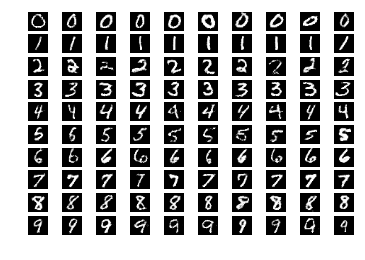

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# sampling from generator
sample_codes = enc.transform(np.arange(10).repeat(10)[:, None])
sample_z = np.random.normal(0, .33, (100, 100))
fake_images = G_net.eval({G_feature_z: sample_z, G_feature_code: sample_codes}, outputs=G_net.G_out)


def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(img_w, img_h), vmin=-1., vmax=1., cmap='gray')
        ax.axis('off')
    plt.show()


plot_images(fake_images, [10, 10])